In [1]:
import numpy as np
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [93]:
N = 200

X = np.random.uniform(low=-50, high=50, size=(N, 2))
G = np.random.randint(low=0,high=2,size=(N,1))
alpha = np.array([10,12])
beta = np.array([[-20,5]])
eps = np.random.randn(N,2)
MU = alpha + G@beta + eps

T = (MU*X)@np.ones((2,1)) + 0*np.random.normal(size=(N, 1), scale=1)
print(T.shape, X.shape, MU.shape)
print(alpha,beta)
print(len(np.unique(G)))

(200, 1) (200, 2) (200, 2)
[10 12] [[-20   5]]
2


In [130]:
G@beta

array([[  0,   0],
       [-20,   5],
       [  0,   0],
       [  0,   0],
       [-20,   5],
       [  0,   0],
       [-20,   5],
       [-20,   5],
       [  0,   0],
       [  0,   0],
       [  0,   0],
       [-20,   5],
       [  0,   0],
       [-20,   5],
       [-20,   5],
       [-20,   5],
       [  0,   0],
       [-20,   5],
       [  0,   0],
       [  0,   0],
       [  0,   0],
       [-20,   5],
       [-20,   5],
       [-20,   5],
       [-20,   5],
       [-20,   5],
       [-20,   5],
       [  0,   0],
       [-20,   5],
       [-20,   5],
       [-20,   5],
       [-20,   5],
       [-20,   5],
       [-20,   5],
       [  0,   0],
       [-20,   5],
       [  0,   0],
       [  0,   0],
       [  0,   0],
       [-20,   5],
       [-20,   5],
       [  0,   0],
       [-20,   5],
       [-20,   5],
       [  0,   0],
       [  0,   0],
       [-20,   5],
       [  0,   0],
       [  0,   0],
       [-20,   5],
       [  0,   0],
       [  0,   0],
       [-20,

-0.3782185694497008
-0.8824334834892069


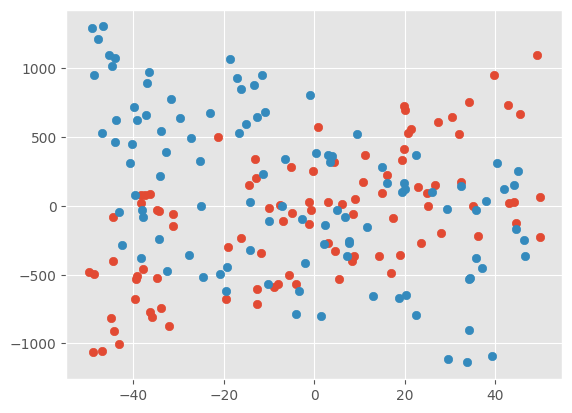

In [87]:
import scipy.stats

print(MU[:,0].mean())
result = scipy.stats.linregress(X[:,0], T[:,0])
print(result.slope)
plt.scatter(X[G[:,0]==0,0],T[G[:,0]==0])
plt.scatter(X[G[:,0]==1,0],T[G[:,0]==1])

14.651749828650757
14.671514201397304


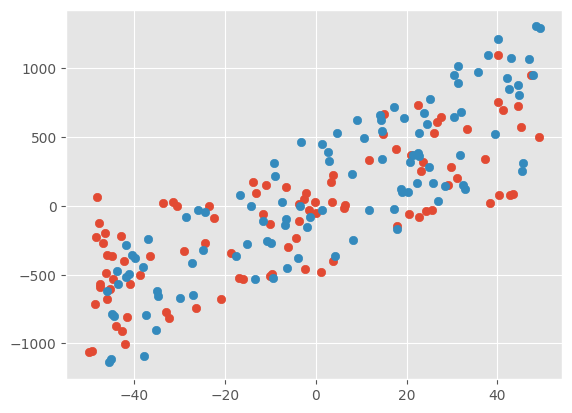

In [88]:
print(MU[:,1].mean())
result = scipy.stats.linregress(X[:,1], T[:,0])
print(result.slope)
plt.scatter(X[G[:,0]==0,1],T[G[:,0]==0])
plt.scatter(X[G[:,0]==1,1],T[G[:,0]==1])

In [89]:
def log_norm(x, mu, std):
    """Compute the log pdf of x,
    under a normal distribution with mean mu and standard deviation std."""
    
    return -0.5 * torch.log(2*np.pi*std**2) -(0.5 * (1/(std**2))* (x-mu)**2)

In [117]:
class VI2LevelModule(torch.nn.Module):
    def __init__(self,
                 in_features,
                 out_features,
                 n_groups):
        super(VI2LevelModule, self).__init__()
        self.n_latent = 100 # Number of latent samples
        self.softplus = torch.nn.Softplus()
        self.in_features = in_features
        self.out_features = out_features
        self.n_groups = n_groups
        
        #The parameters we adjust during training.
        self.group_to_params = []

        self.mu_m = torch.nn.Parameter(torch.randn(in_features,out_features), requires_grad=True)
        self.mu_s = torch.nn.Parameter(torch.randn(in_features,out_features), requires_grad=True)

        self.tau = torch.nn.Parameter(torch.randn(in_features,out_features), requires_grad=True)

        self.sigma = torch.nn.Parameter(torch.randn(in_features,out_features), requires_grad=True)

        for _ in range(self.n_groups):
            mu_j = torch.nn.Parameter(torch.randn(in_features,out_features), requires_grad=True)
            self.group_to_params.append({"mu":mu_j})
            
        
        #create holders for prior mean and std, and likelihood std.
        self.prior_mu_m = Variable(torch.randn(in_features,out_features), requires_grad=False)
        self.prior_mu_s = Variable(torch.randn(in_features,out_features), requires_grad=False)

        self.likelihood_s = Variable(torch.FloatTensor((1)), requires_grad=False)
        
        #Set the prior and likelihood moments.
        self.prior_mu_m.data.fill_(11.0)
        self.prior_mu_s.data.fill_(2)

        self.likelihood_s.data.fill_(5.5)
     
        
    def generate_rand(self):
        return np.random.normal(size=(self.n_latent,self.in_features,self.out_features))
    
    def reparam(self):
        sampled_group_to_params = []
        
        eps_mu = self.generate_rand()
        eps_mu = Variable(torch.FloatTensor(eps_mu))
        sampled_mu = (eps_mu*self.softplus(self.mu_s)).add(self.mu_m) # TODO learn mu, mu_s

        for j in range(self.n_groups):
            eps_mu_j = self.generate_rand()
            eps_mu_j = Variable(torch.FloatTensor(eps_mu_j))
            sampled_mu_j = (eps_mu_j*self.softplus(self.tau)).add(self.group_to_params[j]["mu"])

            eps_theta_j = self.generate_rand()
            eps_theta_j = Variable(torch.FloatTensor(eps_theta_j))
            sampled_theta_j = (eps_theta_j*self.softplus(self.sigma)).add(sampled_mu_j)

            sampled_group_to_params.append({"mu":sampled_mu_j,"theta":sampled_theta_j})

        return  sampled_mu, sampled_group_to_params
    
    def compute_elbo(self, x, t, groups_mask):
        sampled_mu, sampled_group_to_params = self.reparam()

        elbo = 0
        # level 1
        for j in range(self.n_groups):
            q_likelihood = log_norm(sampled_group_to_params[j]["theta"], sampled_group_to_params[j]["mu"], self.softplus(self.sigma))
            q_likelihood = torch.mean(q_likelihood)

            prior = log_norm(sampled_group_to_params[j]["mu"], sampled_mu, self.softplus(self.tau))
            prior = torch.mean(prior)

            preds = torch.einsum("ij,kjl->kil",x[groups_mask == j],sampled_group_to_params[j]["theta"])
            likelihood = torch.mean(torch.sum(log_norm(t[groups_mask == j], preds, self.likelihood_s), 0))
            
            kld_mc = q_likelihood - prior
            elbo += likelihood - kld_mc

        # level 2
        q_likelihood = log_norm(sampled_mu, self.mu_m, self.softplus(self.mu_s))
        q_likelihood = torch.mean(q_likelihood)

        prior = log_norm(sampled_mu, self.prior_mu_m, self.softplus(self.prior_mu_s))
        prior = torch.mean(prior)
        
        kld_mc = q_likelihood - prior
        elbo += 0 - kld_mc # no likelihood

        return elbo

In [114]:
x = torch.randn(10,2)
z = torch.randn(5,2,1)
res = torch.einsum("ij,kjl->kil",x,z)

for k in range(z.size(0)):
    for i in range(x.size(0)):
        res_man = x[i] @ z[k]
        assert torch.allclose(res[k,i],res_man)



In [118]:
c = VI2LevelModule(
    in_features = 2,
    out_features = 1,
    n_groups = len(np.unique(G)))
print(c.n_groups)

optimizer = torch.optim.Adam(c.parameters(),lr=0.2)
x = Variable(torch.Tensor(X), requires_grad=False) 
group_mask = Variable(torch.Tensor(G).squeeze(), requires_grad=False)
t = Variable(torch.Tensor(T), requires_grad=False)

for i in range(3000):
    loss = -c.compute_elbo(x, t, group_mask)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    if i % 250 ==0:
        print([c.group_to_params[i]["mu"].data.numpy() for i in range(c.n_groups)])
        print(c.mu_m.data.numpy())
        print(c.mu_s.data.numpy())
        print((c.softplus(c.sigma).data**2).numpy())
        print((c.softplus(c.tau).data**2).numpy())

2
[array([[-0.07036452],
       [ 0.9685048 ]], dtype=float32), array([[-0.07085185],
       [ 0.34330902]], dtype=float32)]
[[-0.47332436]
 [-1.1185145 ]]
[[-1.0535669 ]
 [ 0.09815219]]
[[0.05312414]
 [0.02885023]]
[[0.07866812]
 [0.16101171]]
[array([[-0.07036452],
       [ 0.9685048 ]], dtype=float32), array([[-0.07085185],
       [ 0.34330902]], dtype=float32)]
[[-0.07864755]
 [ 0.65130043]]
[[-2.702107]
 [-3.296366]]
[[0.0001773 ]
 [0.00129887]]
[[0.00511573]
 [0.0032602 ]]
[array([[-0.07036452],
       [ 0.9685048 ]], dtype=float32), array([[-0.07085185],
       [ 0.34330902]], dtype=float32)]
[[-0.07168484]
 [ 0.683173  ]]
[[-4.8062572]
 [-3.0114326]]
[[3.7946247e-05]
 [1.0414491e-04]]
[[0.00014977]
 [0.00432505]]
[array([[-0.07036452],
       [ 0.9685048 ]], dtype=float32), array([[-0.07085185],
       [ 0.34330902]], dtype=float32)]
[[-0.06461807]
 [ 0.64709806]]
[[-4.941287 ]
 [-3.3405163]]
[[1.8680021e-04]
 [3.7634880e-05]]
[[7.7393648e-05]
 [2.0179374e-03]]
[array([[-0.0703

In [129]:
c.group_to_params

[{'mu': Parameter containing:
  tensor([[-0.0704],
          [ 0.9685]], requires_grad=True)},
 {'mu': Parameter containing:
  tensor([[-0.0709],
          [ 0.3433]], requires_grad=True)}]

In [128]:
alpha + np.array([[0],[1]])@beta 

array([[ 10,  12],
       [-10,  17]])

In [121]:
X.T @ T

array([[  -3327.00298625],
       [3100652.28230561]])

In [122]:
analytical_posterior_mean = analytical_posterior_var@(0.9+((1/5.5**2)*X.T @ T))
analytical_posterior_mean, c.mu_m.data.numpy()

(array([[251.08814298],
        [ 16.81230335]]),
 array([[-0.07122659],
        [ 0.6527577 ]], dtype=float32))

In [77]:
analytical_posterior_mean.shape

(2, 1)

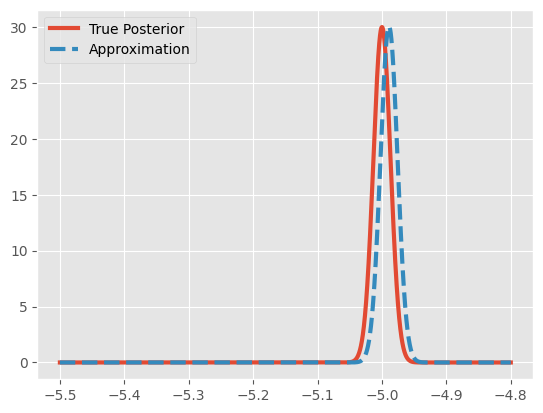

In [89]:
from scipy.stats import norm
param_in, param_out = 1,0
xn = np.arange(-5.5, -4.8, 0.0001)
true_dist = norm(loc = -5, 
                 scale =(analytical_posterior_var[param_in, param_in])**0.5)
q_dist = norm(loc = c.qm[param_in, param_out].data.numpy(), scale = c.softplus(c.qs[param_in, param_out]).data.numpy())
yn = true_dist.pdf(xn).ravel()
plt.plot(xn, yn, linewidth=3, label="True Posterior")
plt.plot(xn, q_dist.pdf(xn).ravel(), '--', linewidth=3,
         label="Approximation")
plt.legend()

In [83]:
yn

array([nan, nan, nan, ..., nan, nan, nan])